# SIR Network Simulations

This notebook creates a collaboration network of researchers and 

In [98]:
# Imports
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import networkx as nx
import warnings

# Submodules
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from EoN import fast_SIR, fast_SIS
from pandarallel import pandarallel

# Configuration
tqdm.pandas()
sns.set()
pandarallel.initialize(progress_bar=True)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [103]:
def get_num_infected(g, rating, initial, tau_factor=.01, gamma=.2, n_repeats=100, tmax=2):
    infected = np.zeros(n_repeats)
    for i in range(n_repeats):
        out = fast_SIR(g, rating*tau_factor, gamma, initial_infecteds=initial_infected, tmax=tmax)
        infected[i] = np.sum([arr[-1] for arr in out[-2:]])
    return infected.mean()
    

In [104]:
# Load collaboration network data
edge_list = pickle.load(open('../data/edges/edge_list.pkl', 'rb'))
edge_list[:5]
g = nx.Graph()
g.add_edges_from(edge_list)

In [105]:
# Patient zero
patient_zero = pd.read_pickle("../data/patient_zero_data.pkl")
patient_zero['initial_cases'] = patient_zero.founders_network.map(lambda l: [x['AuId'] for x in l])
patient_zero

,mag_id,rating,prestige,descendants,n_descendants,descendants_network,founders_network,initial_cases
3,2962891854,6.333333,0.426472,"{2964267256, 2962732398}",2,"[{'AuN': 'haichao zhang', 'AuId': 2135445600, ...","[{'AuN': 'haichao zhang', 'AuId': 2135445600, ...","[2135445600, 2150512450, 2695418315, 290292702..."
9,2963420658,7.000000,0.662641,"{2963938169, 3034834827, 2972376180}",3,"[{'AuN': 'aaditya prakash', 'AuId': 2531407982...","[{'AuN': 'aaditya prakash', 'AuId': 2531407982...","[2531407982, 696551267, 2096808804, 2109608981..."
11,2923023063,6.000000,0.393117,"{2994753955, 2995210711}",2,"[{'AuN': 'jacob beck', 'AuId': 2884496934, 'Af...","[{'AuN': 'jacob beck', 'AuId': 2884496934, 'Af...","[2884496934, 2128714294, 3000054061, 341038388..."
16,2963564796,6.333333,0.826825,"{2995807242, 3035355914, 2995638926, 299592360...",25,"[{'AuN': 'seohyun back', 'AuId': 2886766219, '...","[{'AuN': 'seohyun back', 'AuId': 2886766219, '...","[2886766219, 2995349293, 2995726838, 273323480..."
17,2963477238,6.666667,0.426472,"{2963912736, 3034693764, 2953365509, 296430164...",5,"[{'AuN': 'guoyin wang', 'AuId': 2749292628, 'A...","[{'AuN': 'guoyin wang', 'AuId': 2749292628, 'A...","[2749292628, 2520266005, 2547034632, 251556465..."
...,...,...,...,...,...,...,...,...
405,2963780574,6.250000,0.842317,"{2995058766, 2995372087}",2,"[{'AuN': 'henry zhu', 'AuId': 2897915262, 'AfN...","[{'AuN': 'henry zhu', 'AuId': 2897915262, 'AfN...","[2897915262, 2995453652, 2197765385, 299596810..."
406,2963088756,5.666667,0.857809,"{2967186499, 2995849700, 3034376488, 303472852...",9,"[{'AuN': 'khanh nguyen', 'AuId': 2557541860, '...","[{'AuN': 'khanh nguyen', 'AuId': 2557541860, '...","[2557541860, 2129358305, 2095316779, 216565969..."
407,2787178869,7.000000,0.505026,{2994984846},1,"[{'AuN': 'sejun park', 'AuId': 2486030179, 'Af...","[{'AuN': 'sejun park', 'AuId': 2486030179, 'Af...","[2486030179, 2995442791, 2907807185, 2298251316]"
411,2964139811,6.666667,0.357735,{2963532621},1,"[{'AuN': 'guoliang kang', 'AuId': 2745716684, ...","[{'AuN': 'guoliang kang', 'AuId': 2745716684, ...","[2745716684, 2118651624, 2430169722, 2113269357]"


In [106]:
patient_zero['simulated_infections'] = patient_zero[['rating','initial_cases']].parallel_apply(lambda x: get_num_infected(g, x[0], x[1]), axis=1)

In [107]:
patient_zero['author_infections'] = patient_zero[['descendants_network',
                                                  'founders_network']
                                                ].progress_apply(lambda x: 
                                                                len(set([a['AuId'] for a in x[0]] + 
                                                                        [b['AuId'] for b in x[1]])), 
                                                                axis=1)
patient_zero

,mag_id,rating,prestige,descendants,n_descendants,descendants_network,founders_network,initial_cases,simulated_infections,author_infections
3,2962891854,6.333333,0.426472,"{2964267256, 2962732398}",2,"[{'AuN': 'haichao zhang', 'AuId': 2135445600, ...","[{'AuN': 'haichao zhang', 'AuId': 2135445600, ...","[2135445600, 2150512450, 2695418315, 290292702...",927.66,8
9,2963420658,7.000000,0.662641,"{2963938169, 3034834827, 2972376180}",3,"[{'AuN': 'aaditya prakash', 'AuId': 2531407982...","[{'AuN': 'aaditya prakash', 'AuId': 2531407982...","[2531407982, 696551267, 2096808804, 2109608981...",978.21,10
11,2923023063,6.000000,0.393117,"{2994753955, 2995210711}",2,"[{'AuN': 'jacob beck', 'AuId': 2884496934, 'Af...","[{'AuN': 'jacob beck', 'AuId': 2884496934, 'Af...","[2884496934, 2128714294, 3000054061, 341038388...",727.53,11
16,2963564796,6.333333,0.826825,"{2995807242, 3035355914, 2995638926, 299592360...",25,"[{'AuN': 'seohyun back', 'AuId': 2886766219, '...","[{'AuN': 'seohyun back', 'AuId': 2886766219, '...","[2886766219, 2995349293, 2995726838, 273323480...",898.71,110
17,2963477238,6.666667,0.426472,"{2963912736, 3034693764, 2953365509, 296430164...",5,"[{'AuN': 'guoyin wang', 'AuId': 2749292628, 'A...","[{'AuN': 'guoyin wang', 'AuId': 2749292628, 'A...","[2749292628, 2520266005, 2547034632, 251556465...",875.37,22
...,...,...,...,...,...,...,...,...,...,...
405,2963780574,6.250000,0.842317,"{2995058766, 2995372087}",2,"[{'AuN': 'henry zhu', 'AuId': 2897915262, 'AfN...","[{'AuN': 'henry zhu', 'AuId': 2897915262, 'AfN...","[2897915262, 2995453652, 2197765385, 299596810...",708.48,13
406,2963088756,5.666667,0.857809,"{2967186499, 2995849700, 3034376488, 303472852...",9,"[{'AuN': 'khanh nguyen', 'AuId': 2557541860, '...","[{'AuN': 'khanh nguyen', 'AuId': 2557541860, '...","[2557541860, 2129358305, 2095316779, 216565969...",625.41,37
407,2787178869,7.000000,0.505026,{2994984846},1,"[{'AuN': 'sejun park', 'AuId': 2486030179, 'Af...","[{'AuN': 'sejun park', 'AuId': 2486030179, 'Af...","[2486030179, 2995442791, 2907807185, 2298251316]",1016.08,4
411,2964139811,6.666667,0.357735,{2963532621},1,"[{'AuN': 'guoliang kang', 'AuId': 2745716684, ...","[{'AuN': 'guoliang kang', 'AuId': 2745716684, ...","[2745716684, 2118651624, 2430169722, 2113269357]",960.44,4


## Create figures

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


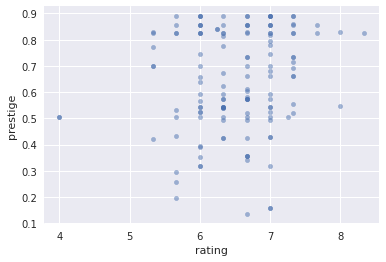

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


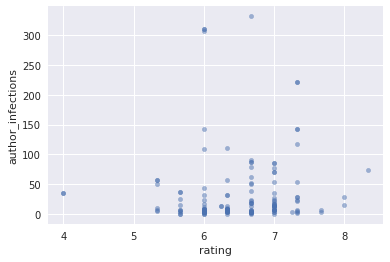

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


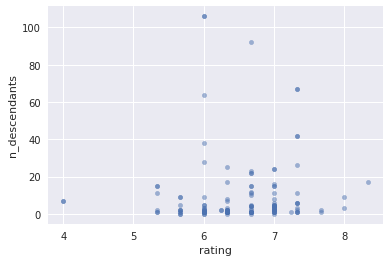

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


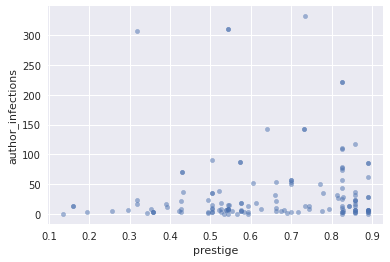

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


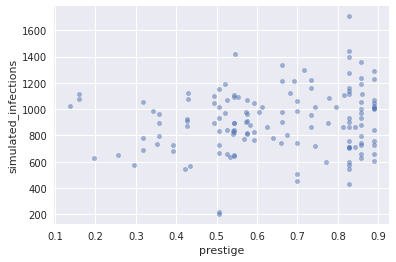

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


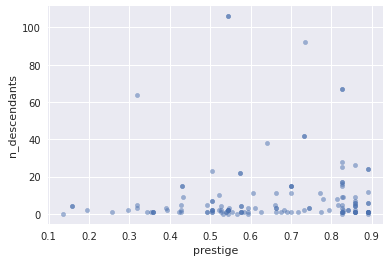

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


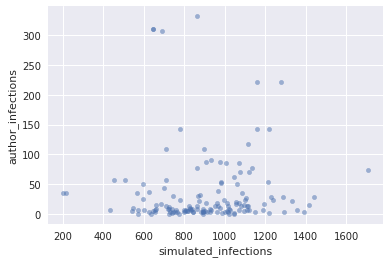

In [109]:
# fig, ax = plt.subplots(3,2)
patient_zero.plot.scatter('rating','prestige', alpha=.5)
plt.show()

patient_zero.plot.scatter('rating','author_infections', alpha=.5)
plt.show()

patient_zero.plot.scatter('rating','n_descendants', alpha=.5)
plt.show()

patient_zero.plot.scatter('prestige','author_infections', alpha=.5)
plt.show()

patient_zero.plot.scatter('prestige','simulated_infections', alpha=.5)
plt.show()

patient_zero.plot.scatter('prestige','n_descendants', alpha=.5)
plt.show()
   
patient_zero.plot.scatter('simulated_infections','author_infections', alpha=.5)
plt.show()

